In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

bits_minuto = 90
pulses_number = 90
distance = 0.6
print(pulses_number)

90


In [211]:
df = pd.DataFrame()

sensor1=np.loadtxt("sensor_data1.txt", delimiter=",")
sensor2=np.loadtxt("sensor_data2.txt", delimiter=",")

if len(sensor1) >= len(sensor2):
    df["sensor2"] = np.loadtxt("sensor_data2.txt", delimiter=",")
    df["sensor1"] = np.loadtxt("sensor_data1.txt", delimiter=",")[:len(sensor2)]
else:
    df["sensor1"] = np.loadtxt("sensor_data1.txt", delimiter=",")
    df["sensor2"] = np.loadtxt("sensor_data2.txt", delimiter=",")[:len(sensor1)]
    

In [212]:
df = df[8000:]
df = df[:-8000]


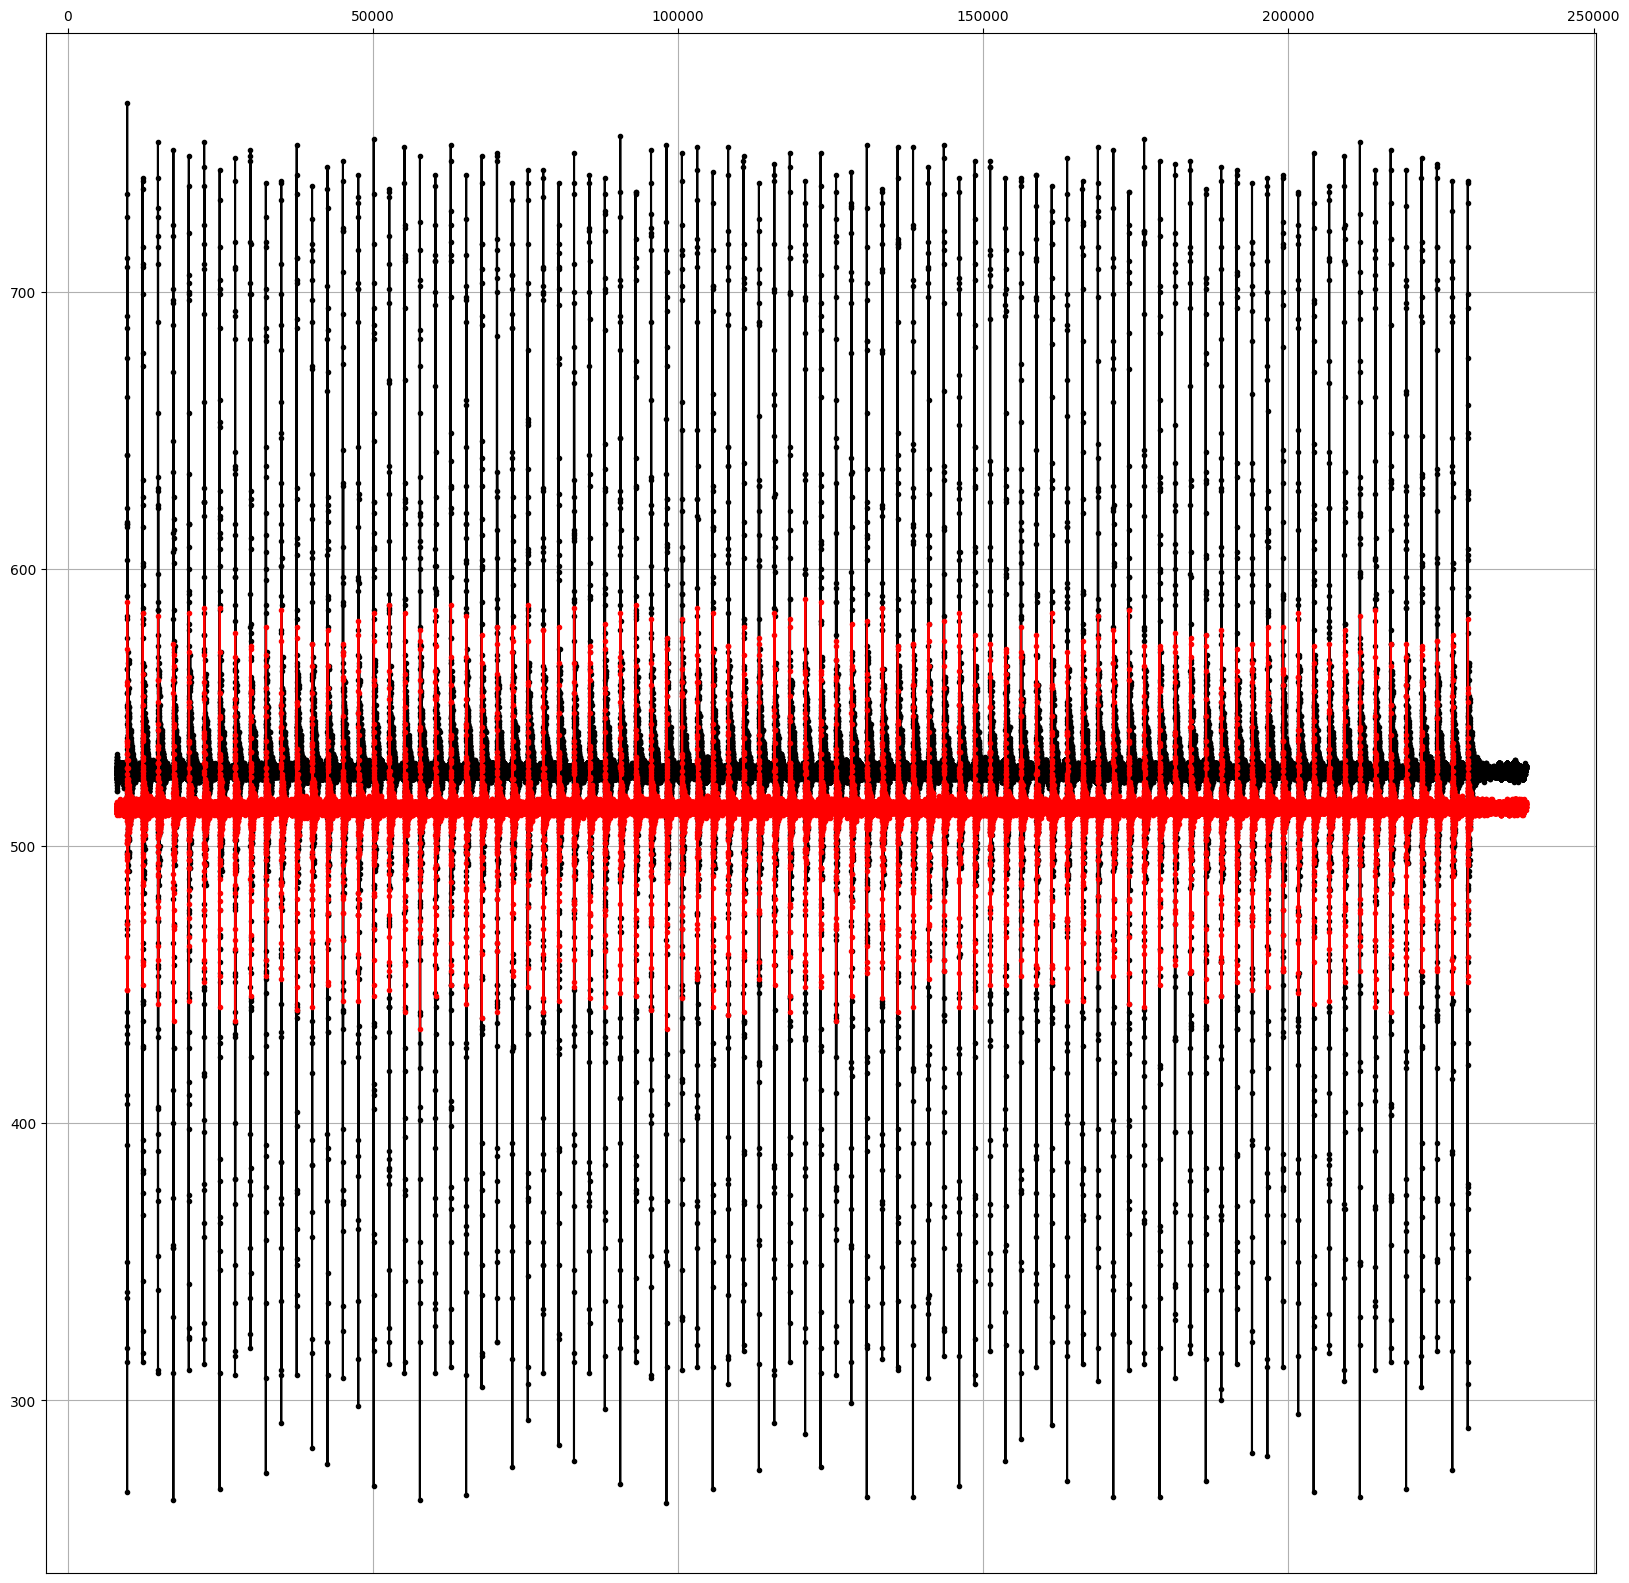

In [213]:
ax = plt.gca()
ax.xaxis.tick_top()
ax.plot(df.index, df["sensor1"], "k.-")
ax.plot(df.index, df["sensor2"], "r.-")
ax.grid()
fig = plt.gcf()
fig.set_size_inches(20, 20)
#x lim
a=4000
b=5000
#plt.xlim(0, 2000)

In [214]:
#import k-means
from sklearn.cluster import KMeans
df = df.reset_index().rename(columns={"index": "time"})

In [215]:
# #try two groups
# kmeans = KMeans(n_clusters=2, random_state=0).fit(df[["sensor1"]])
# df["group"] = kmeans.labels_

In [216]:
# #plot the groups
# ax = plt.gca()
# ax.xaxis.tick_top()
# ax.plot(df[df["group"] == 0]["time"], df[df["group"] == 0]["sensor1"], "k.-", label="Group 0")
# ax.plot(df[df["group"] == 1]["time"], df[df["group"] == 1]["sensor1"], "r.-")
# ax.grid()
# fig = plt.gcf()
# fig.set_size_inches(20, 20)
# ax.legend()


In [217]:
# df = df[df["group"] == 0].drop(columns=["group"])

In [218]:
#identify 20 groups in df_sensor1 by k-means taking time and values into account
kmeans_sensor1 = KMeans(n_clusters=pulses_number, random_state=0).fit(df[["time", "sensor1"]])
kmeans_sensor2 = KMeans(n_clusters=pulses_number, random_state=0).fit(df[["time", "sensor2"]])

#write the clasification for each row in df_sensor1
df["sensor1_pulse"]=kmeans_sensor1.labels_
df["sensor2_pulse"]=kmeans_sensor2.labels_

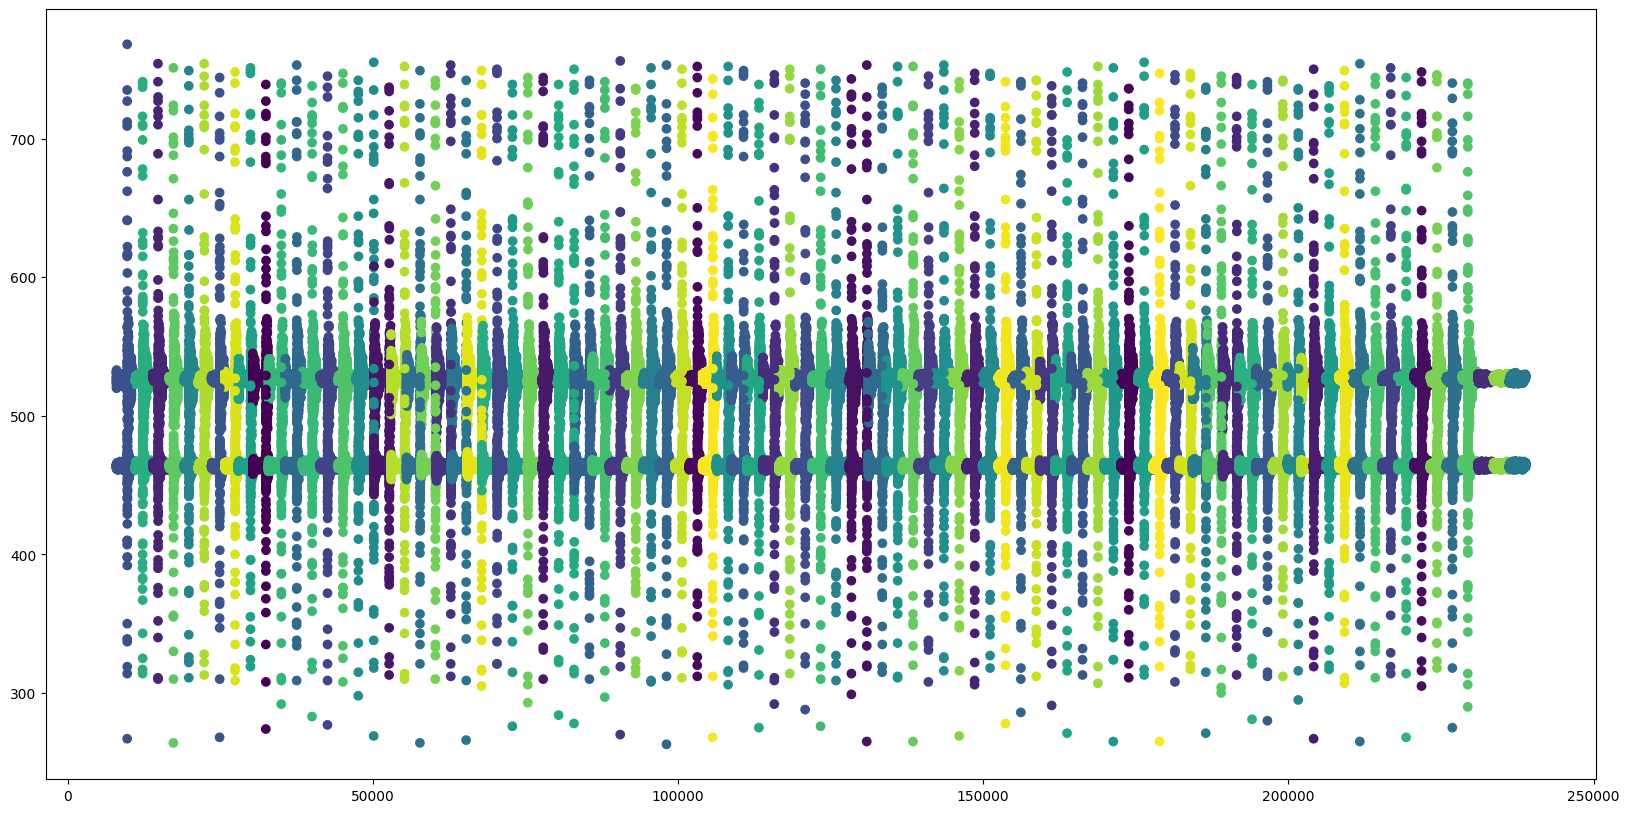

In [219]:
#plot the clasification
plt.figure(figsize=(20, 10))
plt.scatter(df["time"], df["sensor1"], c=df["sensor1_pulse"])
plt.scatter(df["time"], df["sensor2"] - 50, c=df["sensor2_pulse"])
plt.show()


In [220]:
#identify the time of the peak for each group
peaks1 = df[["sensor1", "sensor1_pulse"]].groupby("sensor1_pulse").idxmax().reset_index().rename(columns={"sensor1_pulse": "pulse"})

for pulse in peaks1["pulse"]:
    pulse_df = df.query(f"sensor1_pulse == {pulse}")
    #si el pico no está por encima de la media + 3*desviación estándar, descartar pulso 
    if abs(pulse_df["sensor1"].max()) < pulse_df["sensor1"].mean() + 5*pulse_df["sensor1"].std():
        peaks1 = peaks1.query(f"pulse != {pulse}")

peaks2 = df[["sensor2", "sensor2_pulse"]].groupby("sensor2_pulse").idxmax().reset_index().rename(columns={"sensor2_pulse": "pulse"})

for pulse in peaks2["pulse"]:
    pulse_df = df.query(f"sensor2_pulse == {pulse}")
    #si el pico no está por encima de la media + 3*desviación estándar, descartar pulso 
    if abs(pulse_df["sensor2"].max()) < pulse_df["sensor2"].mean() + 5*pulse_df["sensor2"].std():
        peaks2 = peaks2.query(f"pulse != {pulse}")


In [221]:
peaks = pd.merge(peaks1, peaks2, on="pulse")

In [222]:
peaks

,pulse,sensor1,sensor2
0,0,24460,24478
1,1,165839,165874
2,2,95145,95176
3,3,213818,213839
4,4,122926,122949
...,...,...,...
81,85,59812,59835
82,86,201182,201215
83,87,145645,145666
84,88,97679,97704


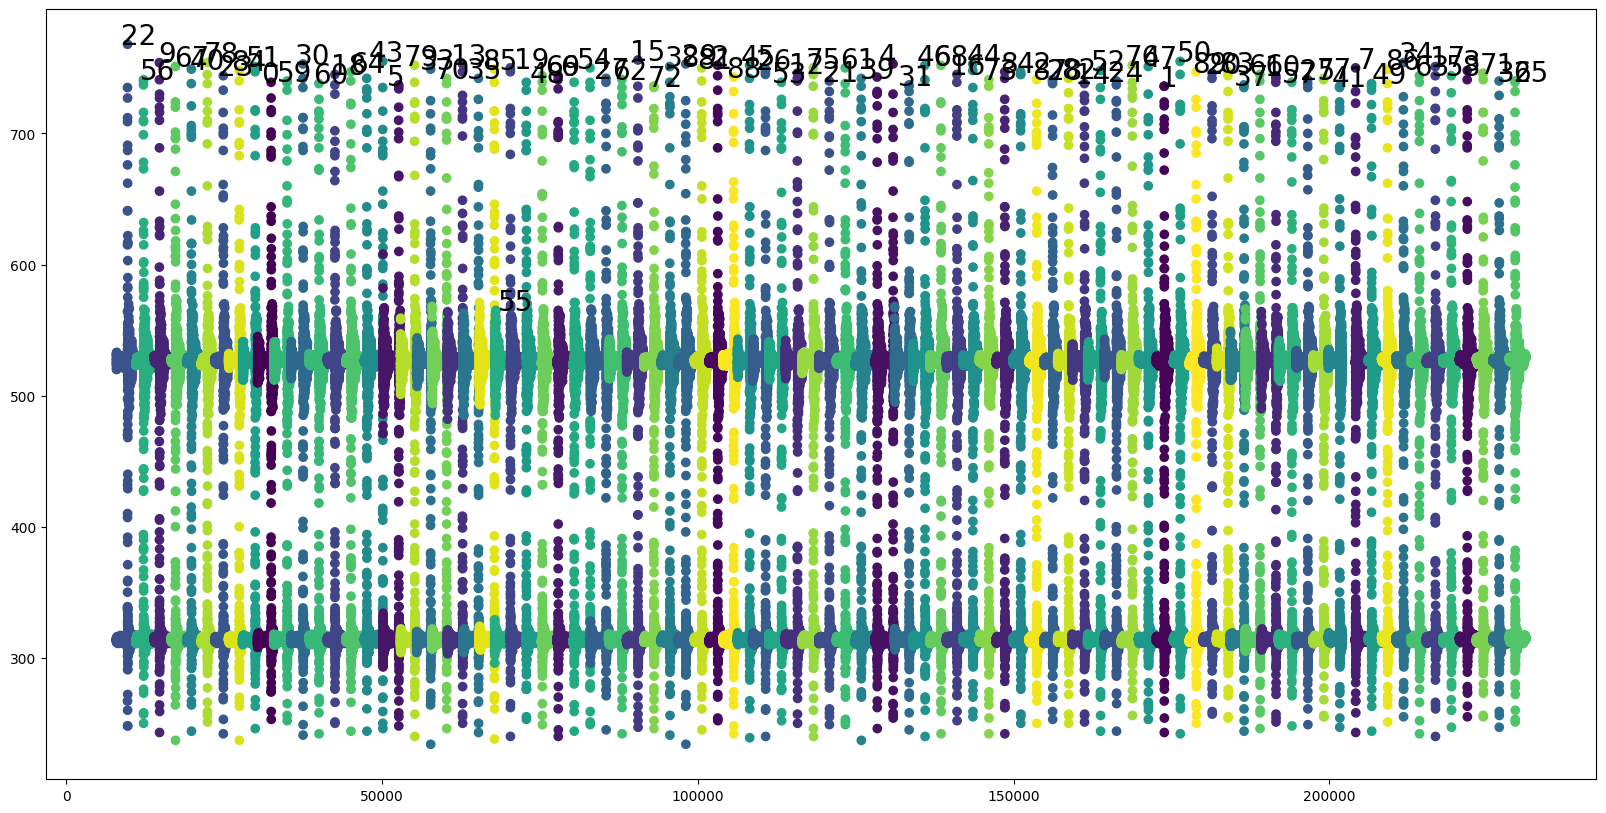

In [223]:
#plot the clasification
df_filtered = df.query("sensor1_pulse in @peaks.pulse and sensor2_pulse in @peaks.pulse")
plt.figure(figsize=(20, 10))
plt.scatter(df_filtered["time"], df_filtered["sensor1"], c=df_filtered["sensor1_pulse"])
plt.scatter(df_filtered["time"], df_filtered["sensor2"] - 200, c=df_filtered["sensor2_pulse"])

#put text over each pulse at the top of the pulse
for peak in peaks["pulse"]:
    peak_df = df_filtered.query(f"sensor1_pulse == {peak}")
    plt.text(peak_df["time"].mean()-peak_df["time"].std(), peak_df["sensor1"].max(), f"{peak}", fontsize=20)
#plt.xlim(4000, 5000)
plt.show()

In [224]:
#df_filtered = df_filtered.query("sensor1_pulse != 17 and sensor2_pulse != 17")

In [225]:
df_filtered = df_filtered[["time", "sensor1", "sensor2"]]

In [226]:
df_filtered

,time,sensor1,sensor2
0,8000,524.0,513.0
1,8001,528.0,513.0
2,8002,531.0,515.0
3,8003,525.0,513.0
4,8004,524.0,513.0
...,...,...,...
223061,231061,529.0,515.0
223062,231062,529.0,515.0
223063,231063,530.0,514.0
223064,231064,529.0,515.0


In [227]:
# n_pulses_reclasified = len(peaks["pulse"])
# kmeans_sensor1 = KMeans(n_clusters=n_pulses_reclasified, random_state=0).fit(df_filtered[["time", "sensor1"]])
# kmeans_sensor2 = KMeans(n_clusters=n_pulses_reclasified, random_state=0).fit(df_filtered[["time", "sensor2"]])

# #write the clasification for each row in df_sensor1
# df_filtered["sensor1_pulse"]=kmeans_sensor1.labels_
# df_filtered["sensor2_pulse"]=kmeans_sensor2.labels_

In [228]:
# #plot the clasification
# plt.figure(figsize=(20, 10))
# plt.scatter(df_filtered["time"], df_filtered["sensor1"], c=df_filtered["sensor1_pulse"])
# plt.scatter(df_filtered["time"], df_filtered["sensor2"] - 50, c=df_filtered["sensor2_pulse"])
# #plt.xlim(4000, 5000)
# plt.show()


In [229]:
# #identify the time of the peak for each group
# peaks1_filtered = df_filtered[["sensor1", "sensor1_pulse"]].groupby("sensor1_pulse").idxmax().reset_index().rename(columns={"sensor1_pulse": "pulse"})

# for pulse in peaks1_filtered["pulse"]:
#     pulse_df = df_filtered.query(f"sensor1_pulse == {pulse}")
#     #si el pico no está por encima de la media + 3*desviación estándar, descartar pulso 
#     if abs(pulse_df["sensor1"].max()) < pulse_df["sensor1"].mean() + 5*pulse_df["sensor1"].std():
#         peaks1_filtered = peaks1_filtered.query(f"pulse != {pulse}")

# peaks2_filtered = df_filtered[["sensor2", "sensor2_pulse"]].groupby("sensor2_pulse").idxmax().reset_index().rename(columns={"sensor2_pulse": "pulse"})

# for pulse in peaks2_filtered["pulse"]:
#     pulse_df = df_filtered.query(f"sensor2_pulse == {pulse}")
#     #si el pico no está por encima de la media + 3*desviación estándar, descartar pulso 
#     if abs(pulse_df["sensor2"].max()) < pulse_df["sensor2"].mean() + 5*pulse_df["sensor2"].std():
#         peaks2_filtered = peaks2_filtered.query(f"pulse != {pulse}")


In [230]:
# peaks_filtered = pd.merge(peaks1_filtered, peaks2_filtered, on="pulse")

In [231]:
# peaks_filtered

In [232]:
# #plot the clasification
# df_refiltered = df_filtered.query("sensor1_pulse in @peaks_filtered.pulse and sensor2_pulse in @peaks_filtered.pulse")
# plt.figure(figsize=(20, 10))
# plt.scatter(df_refiltered["time"], df_refiltered["sensor1"], c=df_refiltered["sensor1_pulse"])
# plt.scatter(df_refiltered["time"], df_refiltered["sensor2"] - 50, c=df_refiltered["sensor2_pulse"])
# #plt.xlim(4000, 5000)
# plt.show()

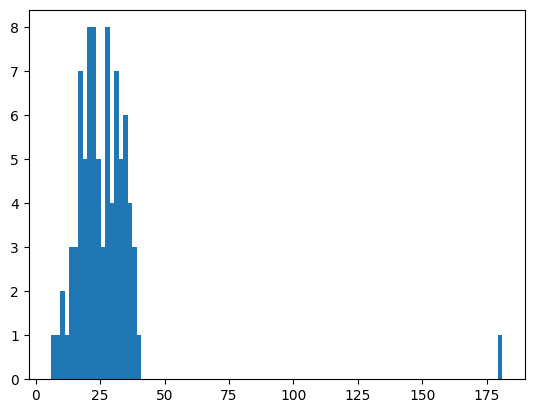

In [233]:
diffs_hist = abs(peaks["sensor1"] - peaks["sensor2"])
#make a histogram of the differences
plt.hist(diffs_hist, bins=100)
plt.show()


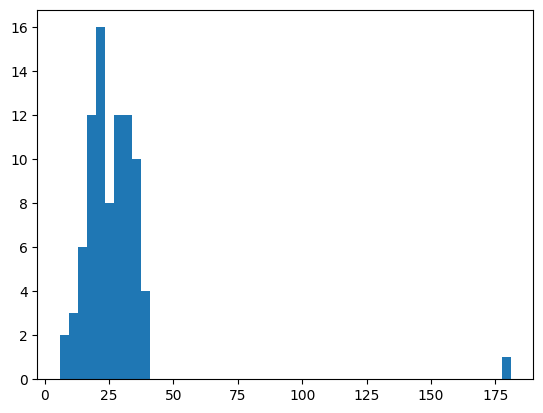

In [234]:
plt.hist(diffs_hist[diffs_hist < 500], bins=50)
plt.show()

In [240]:
gap = int(diffs_hist[diffs_hist<50].mean())

In [241]:
# diffs= abs(peaks_filtered["sensor1"] - peaks_filtered["sensor2"]) # abs(peaks_filtered["sensor1"] - peaks_filtered["sensor2"]).std()
# diffs[np.argmax(diffs)]

In [264]:
time = gap*3/11369
speed = distance/time
pulses_number, speed, gap

(90, 454.76, 5)